### Developing a phylogenetic tree for the used oligonucletide data in this work

This notebook facilitates the implementation of a phylogenetic tree using the processed sequence in this work. For this, the following steps are implemented:

- Read processed sequence in this work
- Make a query to Blast for identifying candidates for a multi alignment sequence process
- Filter candidates based on stablished criteria
- Run a multi alignment sequence
- Process the MSA and prepare data for the development of a phylogenetic tree
- Generate a phylogenetic tree
- Plot phylogenetic tree and save the results

- Process warning

In [64]:
import warnings
warnings.filterwarnings('ignore')

- Auxiliar functions

In [80]:
def apply_process_to_name(title):

    values = title.split("|")
    id_value = values[3]
    names = values[-1]
    names = names.strip()
    names_list = names.split(" ")
    name_data = f"{id_value}| {names_list[0]} {names_list[1]}"
    return name_data

In [65]:
def check_predicted_sequence(title):
    if "PREDICTED" in title:
        return True
    else:
        return False

- Load modules

In [76]:
from Bio.Blast import NCBIWWW, NCBIXML
from Bio import SeqIO, AlignIO, Phylo
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import pandas as pd
import seaborn as sns
import os

- Load input sequence

In [67]:
for record in SeqIO.parse("../raw_data_giannina/oligos_sequences.fasta", "fasta"):
    sequences_to_process = {
        "Organism" : record.description,
        "Sequence" : str(record.seq)
    }

sequences_to_process

{'Organism': 'Study Argopecten purpuratus',
 'Sequence': 'TCAGTTCAACAGTGTTTGGGCATGAGTCTCTACAATGTACTGGTGGTATTGTTTTAGCAGGTGATGCATTTGTTCTACTTCTTCACTGACTAGTGTTTTCACAAAGAATTTCTTATCCTGAGACATCAACATCCGGGCCCCACTCCGGCCGGGGGAGTCTACATCCAACGCCTGCTTAGTTAAGGAGTTCATATAATCTTGGTCATCGATTCCGAATCTCTCCCGGAGATTCCTGAACACAACTGGGCAATACTCCTTACCTTGAAATGACTTGGCATACTTTCTTTGTTGTAAGAATGATTGTCCACTCGTACTTTACTGAACGCTTTAAAATCATCGGGCATCAACATTACAGGAAGGTTCACATGGTTCAAGCCATTTATCGTATGATTAATCCCCCACCAATGACATCTAGAGAATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATGGGAGAGCTCCCAACGCGTTGGATGCATA'}

- Making query to NCBI-BLAST for alignment sequences

In [68]:
query_seq = Seq(sequences_to_process["Sequence"])
record = SeqRecord(query_seq, id="Query1", description=sequences_to_process["Organism"])

print("Sending BLAST query to NCBI...")
result_handle = NCBIWWW.qblast(
    program="blastn",             
    database="nt",                
    sequence=record.format("fasta"),
    hitlist_size=1000,              
    format_type="XML"
)

blast_records = NCBIXML.read(result_handle)

filter_sequences = []

for alignment in blast_records.alignments:
    hsp = alignment.hsps[0]  # high-scoring pair
    
    row = [
        alignment.title,
        hsp.score,
        hsp.sbjct,
        hsp.identities / hsp.align_length
    ]

    filter_sequences.append(row)

df_selected_sequences = pd.DataFrame(
    data=filter_sequences, 
    columns=["title", "score", "sequence", "identity"])

df_selected_sequences.head(5)

Sending BLAST query to NCBI...


,title,score,sequence,identity
0,gi|2835362640|ref|XM_069255312.1| PREDICTED: A...,735.0,CAACAATGTCTGGGCATGAGTCTCTACAATGTACTGGTGGTATTGT...,0.972292
1,gi|1835471732|ref|XR_004536138.1| PREDICTED: P...,625.0,CAGCAATGTCTGAGCATGAGTCTCTACAATGTACTGATGGTACTGT...,0.916877
2,gi|1835471729|ref|XR_004536137.1| PREDICTED: P...,625.0,CAGCAATGTCTGAGCATGAGTCTCTACAATGTACTGATGGTACTGT...,0.916877
3,gi|1835471725|ref|XM_033906951.1| PREDICTED: P...,625.0,CAGCAATGTCTGAGCATGAGTCTCTACAATGTACTGATGGTACTGT...,0.916877
4,gi|1207973896|ref|XM_021522106.1| PREDICTED: M...,581.0,GTCTGGGCATGAGTCTCTACAATGTACTGGTGGTACTGTTTGAGTA...,0.900000


- Removing PREDICTED elements

In [69]:
df_selected_sequences["is_predicted"] = df_selected_sequences["title"].apply(check_predicted_sequence)
df_selected_sequences["is_predicted"].value_counts()

True     906
False     94
Name: is_predicted, dtype: int64

- Checking duplicated sequences

In [89]:
sequences_count = df_selected_sequences.groupby(by="sequence").count().sort_values(by="title", ascending=False)
unique_sequences = sequences_count[sequences_count["title"]==1]
duplicated_sequences = sequences_count[sequences_count["title"]>1]

print()

,title,score,identity,is_predicted,sequence
sequence,,,,,
AATCTTGATCATCAATTCCAAACCTCTCCCGCAGGTTACGGAAGACCATCGGGCAGTATTCCTTAAACTTGAAATGGCTCGGCATGTTTTCTTTGTTAAAAAGGTGATTGTCCACCTTTATTTT--TGAATAGGCTTTGAAGTCATCTGGCATCAACATAACAGGGATTTGAACATGGCTCAGTTCATTGATCGAGTGGTTTACCCCCCAC,28,28,28,28,AATCTTGATCATCAATTCCAAACCTCTCCCGCAGGTTACGGAAGAC...
GAATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATGGGAGAGCTCCCAACGCGTTGGATGCATA,23,23,23,23,GAATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATGGGA...
GAGTTCTGGTAGTCTTGATCGTCAATCCCAAATCTTTCTCGGAGGTTTCGGAACACCAGTGGACAATACTCCTTAAATTTAAAGCGACTTGGCAAGTTTTCCTTGTTGAATAGATGATTGTCCAC-CTTAATCTTACTGTAGGCTTTAAAGTCATCGGGCATTAACATGACAGGGACAGGAACATTGCTGAGTTCATTGATCGTGTGGTTGGCCCCCCAC,20,20,20,20,GAGTTCTGGTAGTCTTGATCGTCAATCCCAAATCTTTCTCGGAGGT...
AATCTTGATCATCAATTCCAAACCTCTCCCGCAGGTTACGGAAGACCATCGGGCAGTATTCCTTAAACTTGAAATGGCTCGGCATGTTTTCTTTGTTAAAAAGGTGATTGTCCACCTTTATTTT--TGAATAGGCTTTGAAGTCATCTGGCATCAACATAACAGGGATTTGAACATGGCTCAGTTCATTGATCGAGTGGTTTACTCCCCAC,14,14,14,14,AATCTTGATCATCAATTCCAAACCTCTCCCGCAGGTTACGGAAGAC...
GAGTTCTGGTAGTCTTGATCGTCAATCCCAAATCTTTCTCGGAGGTTTCGGAACACCAGTGGACAATACTCCTTAAATTTAAAGCGACTTGGCAAGTTCTCCTTGTTGAATAGATGATTGTCCAC-CTTAATCTTACTGTAGGCTTTAAAGTCATCGGGCATTAACATGACAGGAACGGGAACATTGCTGAGTTCGTTGATCGTGTGGTTGGCCCCCCAC,12,12,12,12,GAGTTCTGGTAGTCTTGATCGTCAATCCCAAATCTTTCTCGGAGGT...
...,...,...,...,...,...
CATGACACTCCACAATAAACTGATGGTATTTCTTCAGTATGTTGTGCATTTCTGCTACATCTTCACTTGTTATAGTTTTGATGATATATCTTTTGTCGTAAGATGTATGAAAGCGGGCACCACTGCGTGCTTGGGAATC-ATTGGCAAGGGGTGCACTTCTTGTCAATGAATTCTGAAAGTCTTGATCATCAATTCCAAACCTCTCTCTAAGATTACGGAAAACCATTGGACAATATTCCTTAAATTTGAAATGACTTGGCATGTTTTCTTTGTTGAAAAGGTGATTGTCCACCTTTATCTT--TGAATACGCTTTGAAATCATCTGGCATCAACATAACAGGGATTTGAACATGGCTCA,1,1,1,1,CATGACACTCCACAATAAACTGATGGTATTTCTTCAGTATGTTGTG...
CATGACACTCCACAATAAACTGATGGTATTTCTTCAGTATGTTGTGCATTTCTGCTACATCTTCACTTGTTATAGTTTTGATGATATATCTTTTGTCGTAAGATGTATGAAAGCGGGCACCACTGCGTGCTTGGGAATC-ATTGGCAAGGGGTGCACTTCTTGTCAATGAATTCTGAAAGTCCTGATCATCAATTCCAAATCTCTCTCTTAGATTACGGAAAACCATTGGACAATATTCCTTAAATTTGAAATGACTTGGCATGTTTTCTTTGTTG-AAGAGGTGATTGTCCACCTTTATCTTTGAGTACGCTTTGAAATCATCTGGCATCAACATAACAGGGATTTGAACATGGCTCAGTTCATTGATCTGTGTCATTA,1,1,1,1,CATGACACTCCACAATAAACTGATGGTATTTCTTCAGTATGTTGTG...
CATGACACTCCACAATAAACTGATGGTATTTCTTCAGTATGTTGTGCATTTCTGCTACATCTTCACTTGTTATAGTTTTGATGATATATCTTTTGTCGTAAGATGTATGAAAGCGGGCACCACTGCGTGCTTGGGAATC-ATTGGCAAGGGGTGAACTTCTTGTCAATGAATTCTGAAAGTCTTGATCATCAATTCCAAACCTCTCTCTCAGATTACGGAAAACCATTGGACAATATTCTTTAAATTTGAAATGACTTGGCATGTTTTCTTTGTTGAAAAGGTGATTGTCCACCTTTATCTTTGAGTATGCTTTGAAATCATCTGGCATCAACATAACAGGGATTTGAACATGGCTCAGTTCATTGATCGAGTGGTTGACCCCCCAC,1,1,1,1,CATGACACTCCACAATAAACTGATGGTATTTCTTCAGTATGTTGTG...


In [70]:
df_filter = df_selected_sequences[df_selected_sequences["is_predicted"] == False]
df_filter.shape

(94, 5)

- Checking identity distribution

<Axes: xlabel='identity', ylabel='Count'>

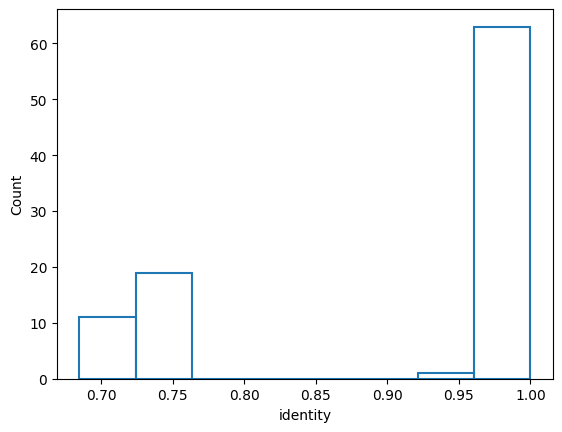

In [71]:
sns.histplot(data=df_filter, x="identity", fill=False)

In [72]:
df_filter.describe()

,score,identity
count,94.000000,94.000000
mean,149.234043,0.908517
std,16.291977,0.126814
min,142.000000,0.684755
25%,142.250000,0.748815
50%,144.000000,0.986842
75%,148.000000,1.000000
max,267.000000,1.000000


- Taking in consideration the statistics descriptors in terms of quantiles, there are no enough information to apply any outlier detector method. Based on this, we will filter for all organisms that has more than 0.95 of identity 

In [73]:
df_filter["is_for_tree"] = (df_filter["identity"]>=0.95).astype(int)
df_filter["is_for_tree"].value_counts()

1    64
0    30
Name: is_for_tree, dtype: int64

In [75]:
df_for_tree = df_filter[df_filter["is_for_tree"]==1]
df_for_tree.shape

(64, 6)

In [78]:
df_for_tree.head(5)

,title,score,sequence,identity,is_predicted,is_for_tree
26,gi|2671790432|gb|PP199098.1| Argopecten irradi...,267.0,CTGGTGGTATTGTTTAAGCAGGTGATGCATCTGTTCTACTTCTTCA...,0.953642,False,1
608,gi|50874046|emb|AJ578646.1| Elaeis guineensis ...,148.0,AGAGAATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATG...,1.000000,False,1
618,gi|17148520|emb|AJ420885.1| Entandrophragma cy...,148.0,AGAGAATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATG...,1.000000,False,1
621,gi|63024995|emb|AJ888986.2| Cocos nucifera mic...,148.0,AGAGAATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATG...,1.000000,False,1
637,gi|17148529|emb|AJ420894.1| Entandrophragma cy...,148.0,AGAGAATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATG...,1.000000,False,1


- Preparing column with the name of the sequences to use

In [81]:
df_for_tree["name"] = df_for_tree["title"].apply(apply_process_to_name)

- Prepare a fasta file for generating the MSA

In [84]:
df_for_tree.to_csv("tmp.csv", index=False)

In [83]:
fasta_file = "tmp.fasta"
records = [
    SeqRecord(Seq(seq), id=seq_id, description="")
    for seq_id, seq in zip(df_for_tree["name"], df_for_tree["sequence"])
]
SeqIO.write(records, fasta_file, "fasta")

64